Import Library

In [103]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [104]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [105]:
# from google.colab import drive
# drive.mount('/content/drive')

Load Dataset

In [106]:
dataset = pd.read_csv('NASDAQCompositeDataset.csv', index_col=0)
#dataset = dataset.iloc[::-1] # reverse the order of dataset


Dataset Preview

In [107]:
dataset

,Date,Price,Open,High,Low,Vol.,Change %
No,,,,,,,
0,9/6/2017,"6,393.31","6,394.35","6,407.40","6,356.20",419.28M,0.28%
1,9/7/2017,"6,397.87","6,402.94","6,413.07","6,379.81",433.05M,0.07%
2,9/8/2017,"6,360.19","6,389.65","6,391.41","6,354.96",408.11M,-0.59%
3,9/11/2017,"6,432.26","6,411.18","6,439.11","6,410.71",431.57M,1.13%
4,9/12/2017,"6,454.28","6,448.81","6,455.02","6,429.54",404.69M,0.34%
...,...,...,...,...,...,...,...
1372,2/17/2023,"11,787.27","11,777.50","11,803.22","11,673.21",966.30M,-0.58%
1373,2/21/2023,"11,492.30","11,640.37","11,684.14","11,491.18",1.02B,-2.50%
1374,2/22/2023,"11,507.07","11,517.20","11,582.52","11,445.17",942.98M,0.13%


Preproccessing Data

1. Filtering Data

In [108]:
dataset=dataset.drop(['Price', 'High', 'Low', 'Vol.', "Change %"], axis=1)
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Open']= dataset['Open'].str.replace(',', '')
dataset

,Date,Open
No,,
0,2017-09-06,6394.35
1,2017-09-07,6402.94
2,2017-09-08,6389.65
3,2017-09-11,6411.18
4,2017-09-12,6448.81
...,...,...
1372,2023-02-17,11777.50
1373,2023-02-21,11640.37
1374,2023-02-22,11517.20


2. Filling Missing Value at Missing Date

In [109]:
dataset = dataset.set_index('Date')
dataset = dataset.resample('D').mean()
dataset = dataset.reset_index()
dataset = dataset.fillna(method='ffill')
dataset

,Date,Open
0,2017-09-06,6394.35
1,2017-09-07,6402.94
2,2017-09-08,6389.65
3,2017-09-09,6389.65
4,2017-09-10,6389.65
...,...,...
1993,2023-02-20,11777.50
1994,2023-02-21,11640.37
1995,2023-02-22,11517.20
1996,2023-02-23,11636.93


3. Reshape Data

4. Normalization Data with MinMaxScaler without Date

In [113]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset["Open"] = pd.to_numeric(dataset["Open"])
scaled_data = scaler.fit_transform(dataset['Open'].values.reshape(-1,1))
scaled_data

array([[0.0138385 ],
       [0.01470943],
       [0.01336198],
       ...,
       [0.53323614],
       [0.54537537],
       [0.52177722]])

5. Split Data

In [114]:
x_train = []
y_train = []
for i in range(60, scaled_data.shape[0]):
    x_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape


((1938, 60, 1), (1938,))

6. Create Data Train

In [115]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1938, 60, 1)

7. Ekstraksi Fitur dengan CNN

In [116]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
31/31 [==============================] - 1s 2ms/step - loss: 0.0278
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/10
31/31 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/10
31/31 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 8/10
31/31 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 9/10
31/31 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 10/10
31/31 [==============================] - 0s 2ms/step - loss: 9.4966e-04


8. Flattening Feature Map

In [117]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=10, batch_size=64)


Epoch 1/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 4/10
31/31 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 7/10
31/31 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 8/10
31/31 [==============================] - 0s 3ms/step - loss: 9.1316e-04
Epoch 9/10
31/31 [==============================] - 0s 3ms/step - loss: 8.7216e-04
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 8.4009e-04


Making LSTM Model with CNN Features Map

In [121]:
LSTM_model = Sequential()
LSTM_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(60, 1)))
LSTM_model.add(MaxPooling1D(pool_size=2))
LSTM_model.add(LSTM(50, activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'], )
LSTM_model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1, shuffle=False, validation_split=0.2,use_multiprocessing=True, workers=6, max_queue_size=20)


Epoch 1/100
25/25 [==============================] - 2s 22ms/step - loss: 0.0490 - accuracy: 0.0013 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0130 - accuracy: 0.0013 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0192 - accuracy: 0.0013 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 4/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0252 - accuracy: 0.0013 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0126 - accuracy: 0.0013 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0258 - accuracy: 0.0013 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 7/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 0.0013 - val_loss: 0.0077 - val

Plot Loss and Accuracy of LSTM Model with CNN Features Map

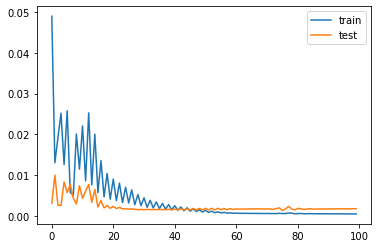

In [122]:
import matplotlib.pyplot as plt
plt.plot(LSTM_model.history.history['loss'], label='train')
plt.plot(LSTM_model.history.history['val_loss'], label='test')
plt.legend()
plt.show()

Make Prediction with LSTM Model with CNN Features Map and Plot the Result with Real Value of NASDAQ Composite Index from 6 September 2017 to 24 Februari 2023

In [126]:
test_start = pd.to_datetime('2017-09-06')
test_end = pd.to_datetime('2023-02-24')
test_data = dataset[(dataset['Date'] >= test_start) & (dataset['Date'] <= test_end)]
test_data

actual_prices = test_data['Open'].values
total_dataset = pd.concat((dataset['Open'], test_data['Open']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - 60:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

# Make predictions on test data

In [127]:

x_test = []
for x in range(60, model_inputs.shape[0]):
    x_test.append(model_inputs[x-60:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices = LSTM_model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot test predictions

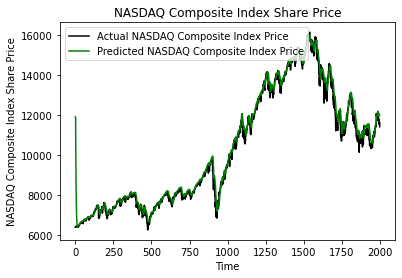

In [128]:

stock = "NASDAQ Composite Index"
plt.plot(actual_prices, color="black", label=f"Actual {stock} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {stock} Price")
plt.title(f"{stock} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{stock} Share Price")
plt.legend()
plt.show()


Measure the RMSE and MAE of LSTM Model with CNN Features Map with Real Value of NASDAQ Composite Index from 6 September 2017 to 24 Februari 2023

In [129]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = math.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 368.9303500050193
MAE: 202.56822578437811


Split Dataset into 3 range time different

In [ ]:
data_before_pandemic=dataset[dataset["Date"] < "3/11/2020"]
data_while_pandemic=dataset[(dataset["Date"] >= "3/11/2020") & (dataset["Date"] <= "9/13/2022")]
data_after_pandemic=dataset[dataset["Date"] > "9/13/2022"]

#Dataset before pandemic

In [ ]:
data_before_pandemic

#Dataset while pandemic

In [ ]:
data_while_pandemic

#Dataset after pandemic

In [ ]:
data_after_pandemic

Normalize Dataset

Split Dataset Into Train and Test Sets

In [ ]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Define a function to create a dataset with look back

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Reshape dataset into X=t and Y=t+1

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Reshape input to be [samples, time steps, features]

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Create and Fit the CNN-LSTM model

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=2)

Make predictions

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


Invert predictions back to original scale

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


calculate root mean squared error (RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))